#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/sol.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8859,1/08/2022,25.860001,25.920000,25.540001,25.850000,25.850000,364476.0,1.35,2.5,125.0
8860,2/08/2022,25.900000,26.190001,25.760000,26.150000,26.150000,352362.0,1.35,2.5,125.0
8861,3/08/2022,26.250000,26.400000,26.040001,26.180000,26.180000,347025.0,1.85,2.5,125.0
8862,4/08/2022,26.299999,26.459999,26.000000,26.000000,26.000000,340849.0,1.85,2.5,125.0
8863,5/08/2022,25.980000,26.010000,25.770000,25.870001,25.870001,281747.0,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# Drop all previous records now in MongoDb
db.sol.drop()

# Insert df records in mongodb
records=df.to_dict('records')
records
db.sol.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.sol.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.sol.delete_one(
    {'Date': last_date}
)



DELETE: 5/08/2022 25.870001


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.sol.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 4/08/2022 26.0
Previous last date in MongoDb: 04-08-2022. Today's date: 30-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'SOL.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-04,26.459999,26.000000,26.299999,26.000000,340849,26.000000
2022-08-05,26.010000,25.770000,25.980000,25.870001,281747,25.870001
2022-08-08,25.879999,25.450001,25.690001,25.799999,283541,25.799999
2022-08-09,26.000000,25.680000,25.760000,25.780001,333358,25.780001
2022-08-10,25.610001,25.320000,25.540001,25.389999,302030,25.389999
2022-08-11,25.980000,25.520000,25.520000,25.930000,273226,25.930000
2022-08-12,26.049999,25.360001,25.900000,25.480000,413214,25.480000
2022-08-15,25.719999,25.420000,25.469999,25.670000,240904,25.670000
2022-08-16,26.090000,25.770000,25.870001,26.020000,266435,26.020000


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-05,26.010000,25.770000,25.980000,25.870001,281747,25.870001
2022-08-08,25.879999,25.450001,25.690001,25.799999,283541,25.799999
2022-08-09,26.000000,25.680000,25.760000,25.780001,333358,25.780001
2022-08-10,25.610001,25.320000,25.540001,25.389999,302030,25.389999
2022-08-11,25.980000,25.520000,25.520000,25.930000,273226,25.930000
2022-08-12,26.049999,25.360001,25.900000,25.480000,413214,25.480000
2022-08-15,25.719999,25.420000,25.469999,25.670000,240904,25.670000
2022-08-16,26.090000,25.770000,25.870001,26.020000,266435,26.020000
2022-08-17,26.250000,26.010000,26.100000,26.219999,286288,26.219999


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,05/08/2022,26.010000,25.770000,25.980000,25.870001,281747,25.870001,1.85,2.5,125
1,08/08/2022,25.879999,25.450001,25.690001,25.799999,283541,25.799999,1.85,2.5,125
2,09/08/2022,26.000000,25.680000,25.760000,25.780001,333358,25.780001,1.85,2.5,125
3,10/08/2022,25.610001,25.320000,25.540001,25.389999,302030,25.389999,1.85,2.5,125
4,11/08/2022,25.980000,25.520000,25.520000,25.930000,273226,25.930000,1.85,2.5,125
5,12/08/2022,26.049999,25.360001,25.900000,25.480000,413214,25.480000,1.85,2.5,125
6,15/08/2022,25.719999,25.420000,25.469999,25.670000,240904,25.670000,1.85,2.5,125
7,16/08/2022,26.090000,25.770000,25.870001,26.020000,266435,26.020000,1.85,2.5,125
8,17/08/2022,26.250000,26.010000,26.100000,26.219999,286288,26.219999,1.85,2.5,125
9,18/08/2022,26.540001,26.139999,26.340000,26.370001,277466,26.370001,1.85,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '05/08/2022',
  'High': 26.010000228881836,
  'Low': 25.770000457763672,
  'Open': 25.979999542236328,
  'Close': 25.8700008392334,
  'Volume': 281747,
  'Adj Close': 25.8700008392334,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '08/08/2022',
  'High': 25.8799991607666,
  'Low': 25.450000762939453,
  'Open': 25.690000534057617,
  'Close': 25.799999237060547,
  'Volume': 283541,
  'Adj Close': 25.799999237060547,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '09/08/2022',
  'High': 26.0,
  'Low': 25.68000030517578,
  'Open': 25.760000228881836,
  'Close': 25.780000686645508,
  'Volume': 333358,
  'Adj Close': 25.780000686645508,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '10/08/2022',
  'High': 25.610000610351562,
  'Low': 25.31999969482422,
  'Open': 25.540000915527344,
  'Close': 25.389999389648438,
  'Volume': 302030,
  'Adj Close': 25.389999389648438,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '11/08/2022',
  'High': 25.9799995422363

In [10]:
#INSERT NEW DATA INTO MONGODB
db.sol.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.sol.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('630dcfa3ab55608a7b69d520') '17/08/2022' 26.100000381469727
  26.25 26.010000228881836 26.219999313354492 26.219999313354492 286288.0
  1.85 2.5 125.0]
 [ObjectId('630dcfa3ab55608a7b69d521') '18/08/2022' 26.34000015258789
  26.540000915527344 26.139999389648438 26.3700008392334 26.3700008392334
  277466.0 1.85 2.5 125.0]
 [ObjectId('630dcfa3ab55608a7b69d522') '19/08/2022' 26.75
  26.84000015258789 26.350000381469727 26.479999542236328
  26.479999542236328 312852.0 1.85 2.5 125.0]
 [ObjectId('630dcfa3ab55608a7b69d523') '22/08/2022' 26.149999618530273
  26.18000030517578 25.864999771118164 25.889999389648438
  25.889999389648438 346161.0 1.85 2.5 125.0]
 [ObjectId('630dcfa3ab55608a7b69d524') '23/08/2022' 25.65999984741211
  25.790000915527344 25.350000381469727 25.399999618530273
  25.399999618530273 367371.0 1.85 2.5 125.0]
 [ObjectId('630dcfa3ab55608a7b69d525') '24/08/2022' 25.700000762939453
  25.889999389648438 25.600000381469727 25.799999237060547
  25.799999237060547 321

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

30/08/2022 25.860000610351562


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.sol.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8732, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6986, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00092496, 0.00092496, 0.00092496, 0.00092496, 0.00092496,
       0.00092496, 0.00092496, 0.00092496, 0.00092496, 0.00092496,
       0.00092496, 0.00092496, 0.00092496, 0.00092496, 0.00092496,
       0.00092496, 0.00092496, 0.00092496, 0.00092496, 0.00092496,
       0.00092496, 0.00092496, 0.00323738, 0.00323738, 0.00323738,
       0.00323738, 0.00323738, 0.00323738, 0.00323738, 0.00323738,
       0.00323738, 0.00323738, 0.00323738, 0.00323738, 0.00323738,
       0.00323738, 0.00323738, 0.00323738, 0.00323738, 0.00323738])]
[0.0032373842850116977]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6926, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6926, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6926/6926 [==============================] - 154s 22ms/step - loss: 1.2463e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.238170026847254

C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/323506912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


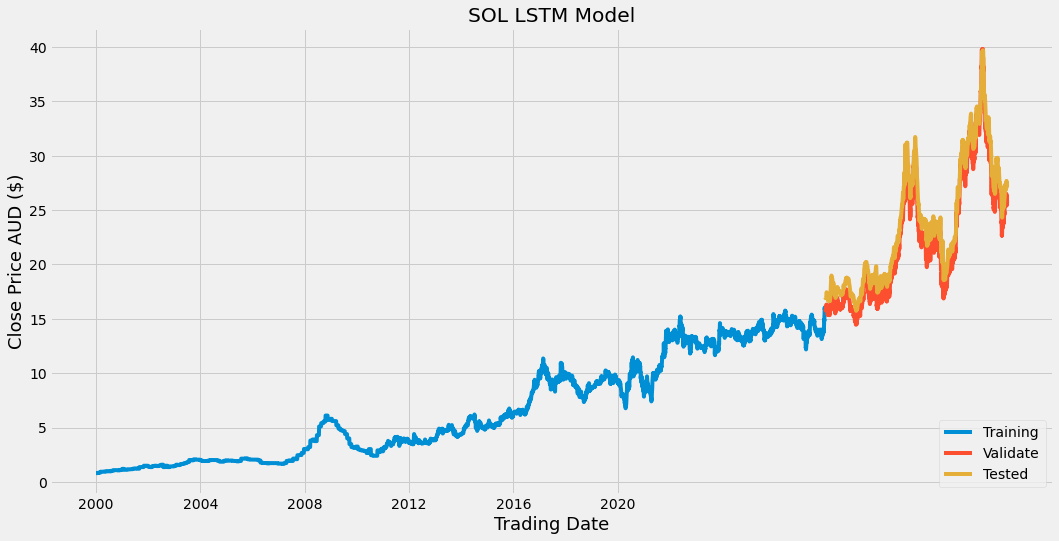

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('SOL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/sol_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6986  15.920000    17.014502   -1.094502
6987  15.900000    17.005661   -1.105661
6988  15.870000    16.975042   -1.105042
6989  15.850000    16.937834   -1.087834
6990  15.840000    16.907372   -1.067372
...         ...          ...         ...
8727  25.799999    27.313414   -1.513414
8728  26.230000    27.146748   -0.916748
8729  26.150000    27.201221   -1.051222
8730  25.650000    27.296669   -1.646669
8731  25.860001    27.232096   -1.372095

[1746 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.sol.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $25.860000610351562 Predicted next day share price $27.0


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/sol_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list sol_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/sol_model.sav')

In [32]:
# query the sol collection and load into dataframe

df_mongo = pd.DataFrame(list(db.sol.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[25.01      ],
       [25.465     ],
       [25.110001  ],
       [24.76      ],
       [23.49      ],
       [23.66      ],
       [23.549999  ],
       [23.059999  ],
       [22.58      ],
       [22.700001  ],
       [22.52      ],
       [22.540001  ],
       [22.790001  ],
       [23.57      ],
       [23.85      ],
       [23.85      ],
       [23.540001  ],
       [23.35      ],
       [23.709999  ],
       [23.59      ],
       [23.4       ],
       [23.41      ],
       [24.030001  ],
       [23.75      ],
       [23.73      ],
       [23.59      ],
       [23.790001  ],
       [23.4       ],
       [23.9       ],
       [24.110001  ],
       [24.370001  ],
       [24.6       ],
       [24.35      ],
       [24.5       ],
       [24.620001  ],
       [24.790001  ],
       [25.15      ],
       [25.41      ],
       [25.540001  ],
       [25.76      ],
       [26.040001  ],
       [26.        ],
       [25.77000046],
       [25.45000076],
       [25.68000031],
       [25

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/sol_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_sol(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_sol(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[25.71,
 25.71,
 25.74,
 25.77,
 25.81,
 25.86,
 25.9,
 25.94,
 25.98,
 26.02,
 26.05,
 26.07,
 26.09,
 26.11,
 26.12,
 26.13,
 26.13,
 26.14,
 26.14,
 26.14,
 26.15,
 26.15,
 26.16,
 26.16,
 26.17,
 26.17,
 26.18,
 26.19,
 26.2,
 26.2,
 26.21,
 26.22,
 26.23,
 26.23,
 26.24,
 26.25,
 26.25,
 26.26,
 26.26,
 26.27,
 26.27,
 26.27,
 26.28,
 26.28,
 26.28,
 26.28,
 26.29,
 26.29,
 26.29,
 26.29,
 26.3,
 26.3,
 26.3,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.28,
 26.28,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.29,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26.3,
 26

In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-08-31 00:00:00 2022-08-30 00:00:00
5:05:21.847972
[[ObjectId('630dc684ae0967d01293931d') 199 '05-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d01293931e') 200 '06-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d01293931f') 201 '07-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939320') 202 '08-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939321') 203 '09-06-2023' 'Friday']
 [ObjectId('630dc684ae0967d012939322') 204 '12-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d012939323') 205 '13-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d012939324') 206 '14-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939325') 207 '15-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939326') 208 '16-06-2023' 'Friday']]


In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,31-08-2022,Wednesday
1,2,01-09-2022,Thursday
2,3,02-09-2022,Friday
3,4,05-09-2022,Monday
4,5,06-09-2022,Tuesday
...,...,...,...
203,204,12-06-2023,Monday
204,205,13-06-2023,Tuesday
205,206,14-06-2023,Wednesday
206,207,15-06-2023,Thursday


In [37]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/719184443.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


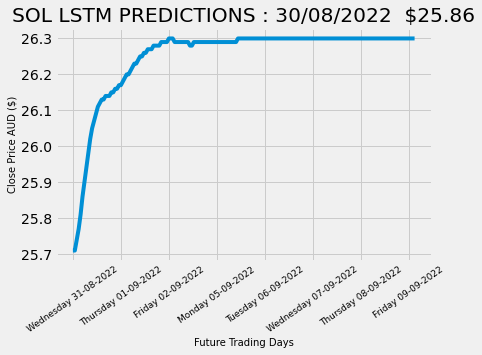

In [38]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('SOL LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/sol_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630dc684ae0967d012939257'), 'Count': 1, 'Date': '31-08-2022', 'DOW': 'Wednesday', 'Price': 25.71}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6986 8732 8895


C:\Users\antoi\AppData\Local\Temp/ipykernel_19560/4026509596.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


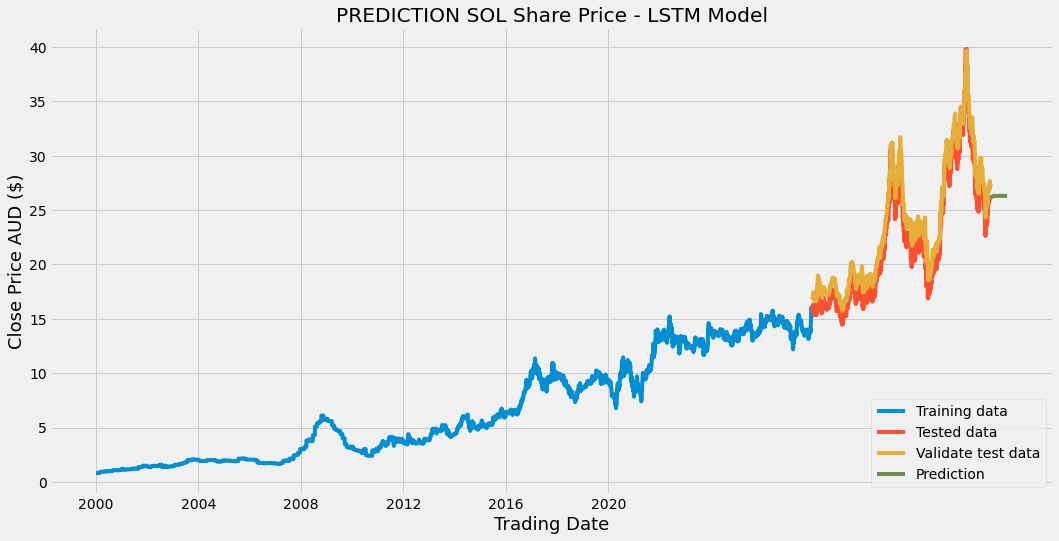

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION SOL Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/sol_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'SOL'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f867c28186dd9129aea8b3'), 'model': 'RFR', 'name': 'SOL', 'date': '12/08/2022', 'predicted': 25, 'actual': 25, 'difference': 0.1119, 'accuracy': 97.48}
{'_id': ObjectId('630ca3a430f57d244fcdb1d2'), 'model': 'LSTM', 'name': 'SOL', 'date': '29/08/2022', 'predicted': 25.06, 'actual': 25.65, 'difference': -0.59, 'rmse': 0.51626}


In [43]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f867c28186dd9129aea8b3'), 'model': 'RFR', 'name': 'SOL', 'date': '12/08/2022', 'predicted': 25, 'actual': 25, 'difference': 0.1119, 'accuracy': 97.48}


In [44]:
# Set keys and values of company
name = 'SOL'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022,predicted $27.0, actual $25.86, difference 1.1400000000000006, rmse 1.23817


In [45]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f867c28186dd9129aea8b3'), 'model': 'RFR', 'name': 'SOL', 'date': '12/08/2022', 'predicted': 25, 'actual': 25, 'difference': 0.1119, 'accuracy': 97.48}
{'_id': ObjectId('630dd04fab55608a7b69d52b'), 'model': 'LSTM', 'name': 'SOL', 'date': '30/08/2022', 'predicted': 27.0, 'actual': 25.86, 'difference': 1.14, 'rmse': 1.23817}


In [46]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'

In [47]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'